# Premier entraînement sur les données Kaggle (binaire)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error




In [7]:
MAX_VOCAB_SIZE = 20000  # Taille du vocabulaire max
MAX_LEN = 256           # Longueur max des séquences
EMBED_DIM = 100         # Dimension des embeddings
HIDDEN_DIM = 128        # Taille des couches LSTM
BATCH_SIZE = 16         # Taille des batchs
EPOCHS = 10              # Nombre d'époques

In [8]:
# Load datasets
train_df_kaggle = pd.read_csv("data/kaggle/preprocessed/train.csv")
test_df_kaggle = pd.read_csv("data/kaggle/preprocessed/test.csv")

In [9]:
def tokenize(text):
    return text.split()

def encode(vocab, text):
    return [vocab.get(tok, 1) for tok in tokenize(text)[:MAX_LEN]]

In [10]:
# Build vocabulary
counter_kaggle = Counter()
for text in train_df_kaggle["text"]:
    tokens_kaggle = tokenize(text)
    counter_kaggle.update(tokens_kaggle)

most_common_kaggle = counter_kaggle.most_common(MAX_VOCAB_SIZE - 2)
vocab_kaggle = {"<PAD>": 0, "<UNK>": 1}
for i, (word, _) in enumerate(most_common_kaggle, start=2):
    vocab_kaggle[word] = i

In [11]:
# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, df, vocab, max_len=512):
        self.texts = [torch.tensor(encode(vocab, text), dtype=torch.long) for text in df["text"]]
        self.labels = torch.tensor(df["label"].values, dtype=torch.long)
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Create attention mask
        attention_mask = torch.ones_like(text)  # 1 for real tokens, 0 for padding
        
        # Ensure the text is of max_len
        if len(text) > self.max_len:
            text = text[:self.max_len]
            attention_mask = attention_mask[:self.max_len]
        else:
            # Padding
            padding_length = self.max_len - len(text)
            text = torch.cat([text, torch.zeros(padding_length, dtype=torch.long)], dim=0)
            attention_mask = torch.cat([attention_mask, torch.zeros(padding_length, dtype=torch.long)], dim=0)

        return {
            "input_ids": text,
            "attention_mask": attention_mask,
            "labels": label
        }

In [12]:
def collate_fn(batch):
    # Sort batch by length for packing
    texts = [item["input_ids"] for item in batch]
    labels = [item["labels"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]
    
    # Pad sequences
    texts = pad_sequence(texts, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    
    # Convert labels to tensor
    labels = torch.tensor(labels)
    
    # Return a dictionary
    return {
        "input_ids": texts,
        "attention_mask": attention_masks,
        "labels": labels
    }

In [13]:
# DataLoaders
train_ds_kaggle = TextDataset(train_df_kaggle, vocab_kaggle)
test_ds_kaggle = TextDataset(test_df_kaggle, vocab_kaggle)

train_loader_kaggle = DataLoader(train_ds_kaggle, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader_kaggle = DataLoader(test_ds_kaggle, batch_size=32, collate_fn=collate_fn)

In [14]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, output_dim, max_len=512, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = self._generate_positional_encoding(max_len, embed_dim)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids) + self.positional_encoding[:input_ids.size(1)].unsqueeze(0).to(input_ids.device)
        x = self.dropout(x)

        if attention_mask is not None:
            # Transformer expects 0 for attend, -inf for mask; convert accordingly
            mask = (attention_mask == 0).to(torch.bool)
        else:
            mask = None

        x = self.transformer_encoder(x, src_key_padding_mask=mask)
        cls_output = x[:, 0, :]  # Use first token ([CLS]-like)
        return self.fc(cls_output)

    def _generate_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe


In [15]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Initialize model

Using device: cuda


In [ ]:
# Model
model_kaggle = TransformerClassifier(
    vocab_size=MAX_VOCAB_SIZE,
    embed_dim=EMBED_DIM, 
    hidden_dim=HIDDEN_DIM, 
    num_heads=2,
    num_layers=2,
    output_dim=len(train_df_kaggle["label"].unique())
)
model_kaggle = model_kaggle.to(device)

# Optimizer / Loss
optimizer_kaggle = torch.optim.AdamW(model_kaggle.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training
for epoch in range(20):
    model_kaggle.train()
    total_loss = 0
    for batch in train_loader_kaggle:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer_kaggle.zero_grad()
        outputs = model_kaggle(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_kaggle.step()
        total_loss += loss.item()
        mean_loss = total_loss/len(train_loader_kaggle)
    print(f"Epoch {epoch+1} Loss_Total: {total_loss:.4f}; Mean_Loss: {mean_loss:.4f}")


In [ ]:
model_kaggle.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader_kaggle:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']
        outputs = model_kaggle(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds))



/usr/local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


              precision    recall  f1-score   support

           0       0.94      0.91      0.92       624
           1       0.92      0.94      0.93       643

    accuracy                           0.93      1267
   macro avg       0.93      0.92      0.92      1267
weighted avg       0.93      0.93      0.92      1267



# Deuxième entraînement sur les données ISOT (binaire)
C'est exactement la même chose. On donne un autre nom au modèle pour pouvoir les conserver et les évaluer plus tard pour la généralisation


In [25]:
# Load datasets
train_df_isot = pd.read_csv("data/isot/preprocessed/train.csv")
test_df_isot = pd.read_csv("data/isot/preprocessed/test.csv")

In [26]:
# Build vocabulary
counter_isot = Counter()
for text in train_df_isot["text"]:
    tokens_isot = tokenize(text)
    counter_isot.update(tokens_isot)

most_common_isot = counter_isot.most_common(MAX_VOCAB_SIZE - 2)
vocab_isot = {"<PAD>": 0, "<UNK>": 1}
for i, (word, _) in enumerate(most_common_isot, start=2):
    vocab_isot[word] = i

In [27]:
# DataLoaders
train_ds_isot = TextDataset(train_df_isot, vocab_isot)
test_ds_isot = TextDataset(test_df_isot, vocab_isot)

train_loader_isot = DataLoader(train_ds_isot, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader_isot = DataLoader(test_ds_isot, batch_size=32, collate_fn=collate_fn)

In [ ]:
# Model
model_isot = TransformerClassifier(
    vocab_size=MAX_VOCAB_SIZE,
    embed_dim=EMBED_DIM, 
    hidden_dim=HIDDEN_DIM, 
    num_heads=2,
    num_layers=2,
    output_dim=len(train_df_isot["label"].unique())
)
model_isot = model_isot.to(device)

# Optimizer / Loss
optimizer_isot = torch.optim.AdamW(model_isot.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training
for epoch in range(20):
    model_isot.train()
    total_loss = 0
    for batch in train_loader_isot:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer_isot.zero_grad()
        outputs = model_isot(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_isot.step()
        total_loss += loss.item()
        mean_loss = total_loss/len(train_loader_isot)
    print(f"Epoch {epoch+1} Loss_Total: {total_loss:.4f}; Mean_Loss: {mean_loss:.4f}")


Epoch 1 Loss_Total: 137.7902; Mean_Loss: 0.1227
Epoch 2 Loss_Total: 40.8721; Mean_Loss: 0.0364
Epoch 3 Loss_Total: 27.9025; Mean_Loss: 0.0248
Epoch 4 Loss_Total: 18.1017; Mean_Loss: 0.0161
Epoch 5 Loss_Total: 14.1309; Mean_Loss: 0.0126
Epoch 6 Loss_Total: 10.9249; Mean_Loss: 0.0097
Epoch 7 Loss_Total: 11.8826; Mean_Loss: 0.0106
Epoch 8 Loss_Total: 10.9838; Mean_Loss: 0.0098
Epoch 9 Loss_Total: 7.7634; Mean_Loss: 0.0069
Epoch 10 Loss_Total: 5.7465; Mean_Loss: 0.0051
Epoch 11 Loss_Total: 7.7743; Mean_Loss: 0.0069
Epoch 12 Loss_Total: 6.5557; Mean_Loss: 0.0058
Epoch 13 Loss_Total: 4.0906; Mean_Loss: 0.0036
Epoch 14 Loss_Total: 5.7161; Mean_Loss: 0.0051
Epoch 15 Loss_Total: 5.4750; Mean_Loss: 0.0049
Epoch 16 Loss_Total: 4.5632; Mean_Loss: 0.0041
Epoch 17 Loss_Total: 3.1083; Mean_Loss: 0.0028
Epoch 18 Loss_Total: 5.1205; Mean_Loss: 0.0046
Epoch 19 Loss_Total: 4.7422; Mean_Loss: 0.0042
Epoch 20 Loss_Total: 4.2083; Mean_Loss: 0.0037


In [ ]:
model_isot.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader_isot:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']
        outputs = model_isot(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4702
           1       0.99      1.00      1.00      4278

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



# Généralisation : Entrainement sur Kaggle et évaluation sur ISOT

In [ ]:
model_kaggle.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader_isot:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']
        outputs = model_kaggle(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.55      0.43      0.48      4702
           1       0.50      0.62      0.55      4278

    accuracy                           0.52      8980
   macro avg       0.52      0.52      0.52      8980
weighted avg       0.53      0.52      0.52      8980



# Généralisation : Entrainement sur ISOT et évaluation sur Kaggle

In [ ]:
model_isot.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader_kaggle:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']
        outputs = model_isot(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds))

NameError: name 'model_isot' is not defined

## Modèle avec probabilité

In [17]:
class TransformerClassifier_proba(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, output_dim, max_len=512, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = self._generate_positional_encoding(max_len, embed_dim)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids) + self.positional_encoding[:input_ids.size(1)].unsqueeze(0).to(input_ids.device)
        x = self.dropout(x)

        if attention_mask is not None:
            # Transformer expects 0 for attend, -inf for mask; convert accordingly
            mask = (attention_mask == 0).to(torch.bool)
        else:
            mask = None

        x = self.transformer_encoder(x, src_key_padding_mask=mask)
        cls_output = x[:, 0, :]  # Use first token ([CLS]-like)
        return torch.sigmoid(self.fc(cls_output))  # proba entre 0 et 1

    def _generate_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe


### kaggle

In [60]:
# Model
model_kaggle_proba = TransformerClassifier_proba(
    vocab_size=MAX_VOCAB_SIZE,
    embed_dim=EMBED_DIM, 
    hidden_dim=HIDDEN_DIM, 
    num_heads=2,
    num_layers=2,
    output_dim = 1
)
model_kaggle_proba = model_kaggle_proba.to(device)

# Optimizer / Loss
optimizer_kaggle_proba = torch.optim.AdamW(model_kaggle_proba.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()  # pas CrossEntropyLoss

# Training
for epoch in range(20):
    model_kaggle_proba.train()
    total_loss = 0
    for batch in train_loader_kaggle:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().unsqueeze(1).to(device)  # reshape pour [batch_size, 1]

        optimizer_kaggle_proba.zero_grad()
        outputs = model_kaggle_proba(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_kaggle_proba.step()
        total_loss += loss.item()
        mean_loss = total_loss/len(train_loader_kaggle)
    print(f"Epoch {epoch+1} Loss_Total: {total_loss:.4f}; Mean_Loss: {mean_loss:.4f}")


Epoch 1 Loss_Total: 107.9066; Mean_Loss: 0.6787
Epoch 2 Loss_Total: 100.5058; Mean_Loss: 0.6321
Epoch 3 Loss_Total: 93.7781; Mean_Loss: 0.5898
Epoch 4 Loss_Total: 90.9514; Mean_Loss: 0.5720
Epoch 5 Loss_Total: 88.9646; Mean_Loss: 0.5595
Epoch 6 Loss_Total: 88.1066; Mean_Loss: 0.5541
Epoch 7 Loss_Total: 87.2134; Mean_Loss: 0.5485
Epoch 8 Loss_Total: 89.4428; Mean_Loss: 0.5625
Epoch 9 Loss_Total: 88.1123; Mean_Loss: 0.5542
Epoch 10 Loss_Total: 86.3431; Mean_Loss: 0.5430
Epoch 11 Loss_Total: 85.8552; Mean_Loss: 0.5400
Epoch 12 Loss_Total: 84.5038; Mean_Loss: 0.5315
Epoch 13 Loss_Total: 84.7407; Mean_Loss: 0.5330
Epoch 14 Loss_Total: 86.4660; Mean_Loss: 0.5438
Epoch 15 Loss_Total: 88.4188; Mean_Loss: 0.5561
Epoch 16 Loss_Total: 88.7426; Mean_Loss: 0.5581
Epoch 17 Loss_Total: 85.9393; Mean_Loss: 0.5405
Epoch 18 Loss_Total: 85.7051; Mean_Loss: 0.5390
Epoch 19 Loss_Total: 86.9671; Mean_Loss: 0.5470
Epoch 20 Loss_Total: 84.7506; Mean_Loss: 0.5330


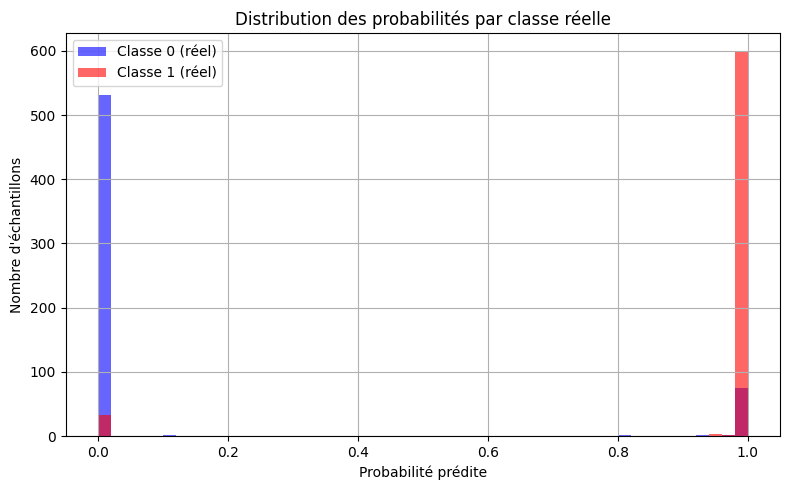

In [61]:
model_kaggle_proba.eval()
all_probs_kaggle = []
all_labels_kaggle = []

with torch.no_grad():
    for batch in test_loader_kaggle:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().unsqueeze(1).to(device)  # [batch_size, 1]

        outputs = model_kaggle_proba(input_ids, attention_mask)  # proba ∈ [0,1]
        all_probs_kaggle.extend(outputs.cpu().numpy().flatten())
        all_labels_kaggle.extend(labels.cpu().numpy().flatten())

# Convert to numpy arrays
all_probs_kaggle = np.array(all_probs_kaggle)
all_labels_kaggle = np.array(all_labels_kaggle)

# Histogramme des probabilités selon la vraie classe
plt.figure(figsize=(8, 5))
plt.hist(all_probs_kaggle[all_labels_kaggle == 0], bins=50, color='blue', alpha=0.6, label='Classe 0 (réel)')
plt.hist(all_probs_kaggle[all_labels_kaggle == 1], bins=50, color='red', alpha=0.6, label='Classe 1 (réel)')
plt.xlabel('Probabilité prédite')
plt.ylabel('Nombre d\'échantillons')
plt.title('Distribution des probabilités par classe réelle')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
model_kaggle_proba.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader_kaggle:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().unsqueeze(1).to(device)  # [batch_size, 1]

        outputs = model_kaggle_proba(input_ids, attention_mask)  # proba ∈ [0,1]
        preds = (outputs > 0.5).int().cpu().numpy()  # seuil à 0.5
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

         0.0       0.94      0.87      0.90       624
         1.0       0.88      0.94      0.91       643

    accuracy                           0.90      1267
   macro avg       0.91      0.90      0.90      1267
weighted avg       0.91      0.90      0.90      1267



In [63]:
model_kaggle_proba.eval()
all_probs_kaggle = []
all_labels_kaggle = []

with torch.no_grad():
    for batch in test_loader_kaggle:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().unsqueeze(1).to(device)  # [batch_size, 1]

        outputs = model_kaggle_proba(input_ids, attention_mask)  # proba ∈ [0,1]
        all_probs_kaggle.extend(outputs.cpu().numpy().flatten())
        all_labels_kaggle.extend(labels.cpu().numpy().flatten())

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(all_labels_kaggle, all_probs_kaggle)
print(f"Erreur quadratique moyenne (MSE) : {mse:.6f}")

Erreur quadratique moyenne (MSE) : 0.092691


### ISOT

In [28]:
# Model
model_isot_proba = TransformerClassifier_proba(
    vocab_size=MAX_VOCAB_SIZE,
    embed_dim=EMBED_DIM, 
    hidden_dim=HIDDEN_DIM, 
    num_heads=2,
    num_layers=2,
    output_dim = 1
)
model_isot_proba = model_isot_proba.to(device)

# Optimizer / Loss
optimizer_isot_proba = torch.optim.AdamW(model_isot_proba.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()  # pas CrossEntropyLoss

# Training
for epoch in range(20):
    model_isot_proba.train()
    total_loss = 0
    for batch in train_loader_isot:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().unsqueeze(1).to(device)  # reshape pour [batch_size, 1]

        optimizer_isot_proba.zero_grad()
        outputs = model_isot_proba(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_isot_proba.step()
        total_loss += loss.item()
        mean_loss = total_loss/len(train_loader_isot)
    print(f"Epoch {epoch+1} Loss_Total: {total_loss:.4f}; Mean_Loss: {mean_loss:.4f}")


Epoch 1 Loss_Total: 660.8612; Mean_Loss: 0.5885
Epoch 2 Loss_Total: 619.3799; Mean_Loss: 0.5515
Epoch 3 Loss_Total: 628.6251; Mean_Loss: 0.5598
Epoch 4 Loss_Total: 615.9405; Mean_Loss: 0.5485
Epoch 5 Loss_Total: 635.5888; Mean_Loss: 0.5660
Epoch 6 Loss_Total: 646.8612; Mean_Loss: 0.5760
Epoch 7 Loss_Total: 660.0683; Mean_Loss: 0.5878
Epoch 8 Loss_Total: 653.4965; Mean_Loss: 0.5819
Epoch 9 Loss_Total: 661.7104; Mean_Loss: 0.5892
Epoch 10 Loss_Total: 655.2345; Mean_Loss: 0.5835
Epoch 11 Loss_Total: 647.1326; Mean_Loss: 0.5763
Epoch 12 Loss_Total: 643.6662; Mean_Loss: 0.5732
Epoch 13 Loss_Total: 647.7870; Mean_Loss: 0.5768
Epoch 14 Loss_Total: 644.6429; Mean_Loss: 0.5740
Epoch 15 Loss_Total: 636.1456; Mean_Loss: 0.5665
Epoch 16 Loss_Total: 630.0046; Mean_Loss: 0.5610
Epoch 17 Loss_Total: 624.6364; Mean_Loss: 0.5562
Epoch 18 Loss_Total: 622.4133; Mean_Loss: 0.5542
Epoch 19 Loss_Total: 623.3957; Mean_Loss: 0.5551
Epoch 20 Loss_Total: 617.7019; Mean_Loss: 0.5500


In [34]:
model_isot_proba.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader_isot:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().unsqueeze(1).to(device)  # [batch_size, 1]

        outputs = model_isot_proba(input_ids, attention_mask)  # proba ∈ [0,1]
        preds = (outputs > 0.5).int().cpu().numpy()  # seuil à 0.5
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94      4702
         1.0       0.91      0.95      0.93      4278

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



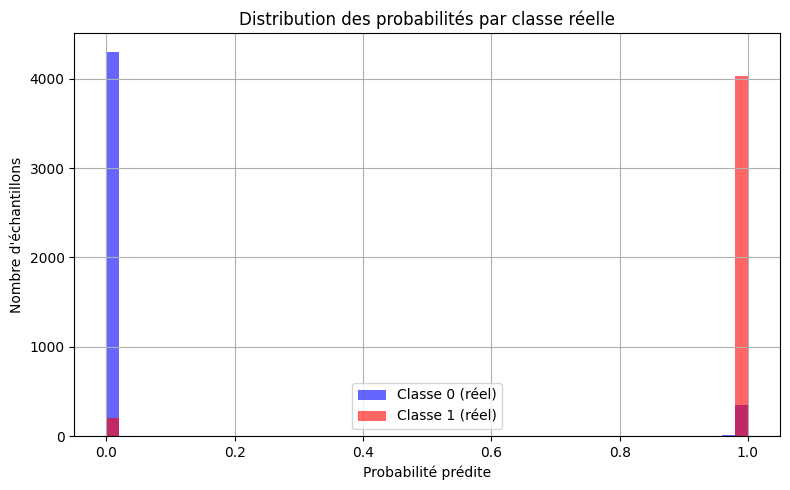

In [35]:
model_isot_proba.eval()
all_probs_isot = []
all_labels = []

with torch.no_grad():
    for batch in test_loader_isot:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().unsqueeze(1).to(device)  # [batch_size, 1]

        outputs = model_isot_proba(input_ids, attention_mask)  # proba ∈ [0,1]
        all_probs_isot.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

# Convert to numpy arrays
all_probs_isot = np.array(all_probs_isot)
all_labels = np.array(all_labels)

# Histogramme des probabilités selon la vraie classe
plt.figure(figsize=(8, 5))
plt.hist(all_probs_isot[all_labels == 0], bins=50, color='blue', alpha=0.6, label='Classe 0 (réel)')
plt.hist(all_probs_isot[all_labels == 1], bins=50, color='red', alpha=0.6, label='Classe 1 (réel)')
plt.xlabel('Probabilité prédite')
plt.ylabel('Nombre d\'échantillons')
plt.title('Distribution des probabilités par classe réelle')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
model_isot_proba.eval()
all_probs_isot = []
all_labels_isot = []

with torch.no_grad():
    for batch in test_loader_isot:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().unsqueeze(1).to(device)  # [batch_size, 1]

        outputs = model_isot_proba(input_ids, attention_mask)  # proba ∈ [0,1]
        all_probs_isot.extend(outputs.cpu().numpy().flatten())
        all_labels_isot.extend(labels.cpu().numpy().flatten())

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(all_labels_isot, all_probs_isot)
print(f"Erreur quadratique moyenne (MSE) : {mse:.6f}")

Erreur quadratique moyenne (MSE) : 0.065682
